# The Structural Relationship of Childcare Expenses and Workforce Attachment
## Jesús Pacheco & Dave Foote

In [95]:
#imports
import numpy as np
import pandas as pd
import scipy.stats as sts
import math
from matplotlib import pyplot as plt
import requests
import scipy.optimize as opt
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
import structural_childcare as sc
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
#read data
df = pd.read_csv('../rdf_subset.csv')
df['intercept'] = 1
state_map = {1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas',
            6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware',
            11: 'D.C.', 12: 'Florida', 13: 'Georgia', 15: 'Hawaii',
            16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa',
            20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana', 23: 'Maine',
            24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan',
            27: 'Minnesota', 28: 'Mississippi', 29: 'Missouri', 30: 'Montana',
            31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire',
            34: 'New Jersey', 35: 'New Mexico', 36: 'New York',
            37: 'North Carolina', 38: 'North Datoka', 39: 'Ohio',
            40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania',
            44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota',
            47: 'Tennessee', 48: 'Texas', 49: 'Utah', 50: 'Vermont',
            51: 'Virginia', 53: 'Washington', 54: 'West Virginia',
            55: 'Wisconsin', 56: 'Wyoming', 60: 'Puerto Rico and Island Areas',
            61: 'Foreign Country'}
bls_data = pd.read_csv('../bls_data.csv')

In [327]:
df['monthly_job_hours'] = df['monthly_job_hrs'] * 4
#one respondant works .25 hours a week and is messing this up:
df.loc[df['monthly_job_hours'] == 1, 'monthly_job_hours'] = .9999

In [98]:
bls_data.State_number = bls_data.State_number.map(state_map)
bls_data.head()

,State_number,STATE_CC_COST,STATE_MEDIAN_WAGE
0,Alabama,9.02,16.22
1,Alaska,12.95,23.09
2,Arizona,11.51,17.80
3,Arkansas,9.44,15.31
4,California,12.67,20.40


In [99]:
state_cc_map = {}
state_medwage_map = {}
for i, r in bls_data.iterrows():
    state_cc_map[r['State_number']] = r['STATE_CC_COST']
    state_medwage_map[r['State_number']] = r['STATE_MEDIAN_WAGE']

In [100]:
df['STATE'] = df.State_number.map(state_map)
df['STATE_CC_COST'] = df.STATE.map(state_cc_map)
df['STATE_MEDIAN_WAGE'] = df.STATE.map(state_medwage_map)

In [106]:
#our functions:
def mle_beta_vec(df, xcols, init_guess, target_col, f):
    '''
    df = dataframe
    xcolumn names in list form
    init_guess in tuple form
    criterion function f
    doin the damn thing (write better comment later)
    '''
    x_mat = extract_x_matrix(df, xcols)
    y_vec = df[target_col]
    
    results_uncstr = opt.minimize(f, init_guess, method = 'L-BFGS-B', args=(x_mat, y_vec))
    VCV = results_uncstr.hess_inv.todense()
    error_info = get_st_error(xcols, VCV)

    return results_uncstr, VCV

def criterion(beta_guess, *args):
    '''
    beta_guess comes in as array
    '''
    x_mat, y_vec = args
    
    
    
    return logit_neglog_likelihood(beta_guess, y_vec, x_mat, prob_1)

def logit_neglog_likelihood(beta_vec, *args):
    '''
    calculate the log likelihood that the probability is correct
    '''
    y_vec, xm, probability_now = args
    p = list(probability_now(xm, beta_vec))
    y_vec = list(y_vec)
    rv = []
    for i, x in enumerate(p):
        to_add = ((y_vec[i] * math.log(x))) + ((1 - y_vec[i]) * math.log(1 - x))
        if to_add is not np.nan:
            rv.append(to_add)
    rv = pd.Series(rv)

    return -(rv.sum())

def prob_1(x_matrix, beta_vec):
    '''
    calculate probability a set of observations is a member of d1, using logit
    classification
    '''
    linear_kernel = x_matrix.dot(beta_vec)
    rv = np.exp(linear_kernel) / (1 + np.exp(linear_kernel))
    rv[rv == 1] = .999999
    rv[rv == 0] = 1e-11

    return rv

def categorical_split(df):
    cond1 = (df['monthly_childcare_expenditure'] == 0)
    cond2 = (df['monthly_childcare_expenditure'] > 0)
    cond3 = (df['monthly_wage'] > 0)
    cond4 = (df['monthly_wage'] == 0)

    return df[cond1 & cond3], df[cond2 & cond3], df[cond4]

def extract_x_matrix(df, xcols):
    '''
    inputs: df with data and column names of your x variables
    output: n x k matrix of x data where n is #observations and k is
    #of columns
    '''
    
    return df[xcols].to_numpy()

def categorize_ds(df):
    '''
    input: df with H and F calculated columns
    output: same df with d1-4 columns denoting membership in groups d1, d2,
    d3, and d4 defined as such:
    d1 - H = 0, F = 0
    d2 - H = 0, F = 1
    d3 - H = 1, F = 0
    d4 - H = 1, F = 1
    '''

    df['d1'] = [1 if (r['H'] == 0) & (r['F'] == 0) else 0 for i, r in df.iterrows()]
    df['d2'] = [1 if (r['H'] == 0) & (r['F'] == 1) else 0 for i, r in df.iterrows()]
    df['d3'] = [1 if (r['H'] == 1) & (r['F'] == 0) else 0 for i, r in df.iterrows()]
    df['d4'] = [1 if (r['H'] == 1) & (r['F'] == 1) else 0 for i, r in df.iterrows()]
    
def get_st_error(col_names, VCV):
    '''
    given the order of the regressors and the variance covariance matrix from 
    the minimization, this function will return a dictionary mapping variable names
    to their standard erros, as well as print this information
    '''
    rd = {}
    for i, x in enumerate(col_names):
        rd[x] = np.sqrt(VCV[i, i])
        print("error for {}: ".format(x), rd[x])

    return rd

# So begins our estimation...
We use categorize_ds to estimate membership in our d groups such that:  
    d1 - H = 0, F = 0  
    d2 - H = 0, F = 1  
    d3 - H = 1, F = 0  
    d4 - H = 1, F = 1  

In [243]:
categorize_ds(df)
est_cols = ['intercept', 'k_under2', 'k_3to5', 'education', 'reg_ratio',
           'monthly_job_hours', 'STATE_CC_COST', 'STATE_MEDIAN_WAGE']
generalized_guess = (.05, .05, .05, .05, .05, .05, .05, .05)

In [121]:
df[df.monthly_job_hours == .9999]

,Unnamed: 0,ssuid,monthly_childcare_expenditure,k_under2,k_3to5,k_6to10,METRO,reg_ratio,criminal_records,daycare_regulations,...,F,intercept,monthly_job_hours,STATE,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4
1108,1109,3.324063e+11,0.0,1.0,0.0,0.0,1.0,10.0,1.0,1.0,...,0,1,0.9999,North Carolina,10.35,17.19,1,0,0,0


In [122]:
results1, errors1 = mle_beta_vec(df, est_cols, generalized_guess, 'd1', criterion)

error for intercept:  64.93196421563994
error for k_under2:  10.661908621122759
error for k_3to5:  0.7949028637718805
error for education:  1.6107810108631393
error for reg_ratio:  2.4079482791630835
error for monthly_job_hours:  0.04411593767263908
error for STATE_CC_COST:  10.74422024191187
error for STATE_MEDIAN_WAGE:  7.724107028753337


In [123]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results1.x[i])

Beta Estimate for intercept : 6.230064906138512
Beta Estimate for k_under2 : 0.21331860039872652
Beta Estimate for k_3to5 : -0.4656634504526347
Beta Estimate for education : -0.13603443694521095
Beta Estimate for reg_ratio : -0.04637165686470501
Beta Estimate for monthly_job_hours : -0.0437388942315292
Beta Estimate for STATE_CC_COST : -0.06282497795996204
Beta Estimate for STATE_MEDIAN_WAGE : -0.051147192328088766


In [124]:
results2, errors2 = mle_beta_vec(df, est_cols, generalized_guess, 'd2', criterion)

error for intercept:  29.90348828271949
error for k_under2:  2.2550547146305675
error for k_3to5:  7.7039764648661055
error for education:  1.351236001675222
error for reg_ratio:  1.8000717538169293
error for monthly_job_hours:  0.06690531870743437
error for STATE_CC_COST:  0.9507038735524167
error for STATE_MEDIAN_WAGE:  1.2323205266295867


In [125]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results2.x[i])

Beta Estimate for intercept : -4.544336685523973
Beta Estimate for k_under2 : -0.1915252291248931
Beta Estimate for k_3to5 : 0.4866002138042188
Beta Estimate for education : 0.1584535381050981
Beta Estimate for reg_ratio : -0.0034668244149025345
Beta Estimate for monthly_job_hours : -0.01684088346851691
Beta Estimate for STATE_CC_COST : -0.05384211876511244
Beta Estimate for STATE_MEDIAN_WAGE : 0.07335954907669937


In [126]:
results3, errors3 = mle_beta_vec(df, est_cols, generalized_guess, 'd3', criterion)

error for intercept:  134.32106793928526
error for k_under2:  3.9927724742921082
error for k_3to5:  4.477355776825626
error for education:  2.4818253900623914
error for reg_ratio:  8.27195231762596
error for monthly_job_hours:  0.3820204438428794
error for STATE_CC_COST:  17.65219464157781
error for STATE_MEDIAN_WAGE:  8.117436959350378


In [127]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results3.x[i])

Beta Estimate for intercept : -1.6973830310774172
Beta Estimate for k_under2 : -0.27348969276867785
Beta Estimate for k_3to5 : -0.5621267716136666
Beta Estimate for education : -0.1266662337673093
Beta Estimate for reg_ratio : 0.04302659514265575
Beta Estimate for monthly_job_hours : 0.023105379035521553
Beta Estimate for STATE_CC_COST : 0.0909717250996231
Beta Estimate for STATE_MEDIAN_WAGE : -0.060384608375909685


In [128]:
results4, errors4 = mle_beta_vec(df, est_cols, generalized_guess, 'd4', criterion)

error for intercept:  284.46060215383375
error for k_under2:  3.1651438759694757
error for k_3to5:  29.556033295612362
error for education:  1.2699707609529347
error for reg_ratio:  6.453149970922487
error for monthly_job_hours:  0.4604829944253569
error for STATE_CC_COST:  25.025185657006872
error for STATE_MEDIAN_WAGE:  29.5640901243362


In [129]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results4.x[i])

Beta Estimate for intercept : -5.525476070413992
Beta Estimate for k_under2 : 0.25975463065297216
Beta Estimate for k_3to5 : 0.5742335349421527
Beta Estimate for education : 0.0960009944542783
Beta Estimate for reg_ratio : -0.023425005027653507
Beta Estimate for monthly_job_hours : 0.022035587557862953
Beta Estimate for STATE_CC_COST : -0.05673592523657938
Beta Estimate for STATE_MEDIAN_WAGE : 0.050114123529715345


# Visualizing Underlying Data:

In [130]:
df.head()

,Unnamed: 0,ssuid,monthly_childcare_expenditure,k_under2,k_3to5,k_6to10,METRO,reg_ratio,criminal_records,daycare_regulations,...,F,intercept,monthly_job_hours,STATE,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4
0,1,114285765.0,0.0,0.0,1.0,0.0,1.0,7.0,1.0,1.0,...,0,1,0.000000,Kansas,9.36,17.28,1,0,0,0
1,2,114552343.0,0.0,0.0,1.0,2.0,1.0,7.0,1.0,1.0,...,0,1,104.166667,Kansas,9.36,17.28,0,0,1,0
2,3,114552369.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,1.0,...,0,1,127.483333,Kansas,9.36,17.28,0,0,1,0
3,4,418037420.0,0.0,1.0,2.0,0.0,1.0,7.0,1.0,1.0,...,0,1,0.000000,Minnesota,11.61,20.49,1,0,0,0
4,5,418086894.0,0.0,0.0,0.0,2.0,0.0,8.0,1.0,1.0,...,0,1,104.833333,Oklahoma,9.27,16.62,0,0,1,0


In [397]:
dave_palette = ["#004067", "#BF4848", "#BA69E0", "#00B14A"]
sns.set(rc={'axes.facecolor':"white", 'font.fantasy':'Chicago', 'axes.edgecolor':'black', 'axes.linewidth':'2',
           'text.color':'black', 'axes.labelcolor':'black', 'ytick.color':'black', 'xtick.color':'black'})

In [398]:
df['category'] = df[['d1', 'd2', 'd3', 'd4']].idxmax(axis=1)

Text(0.5, 1.0, 'Our Categorizations (and the censors they are bounded by)')

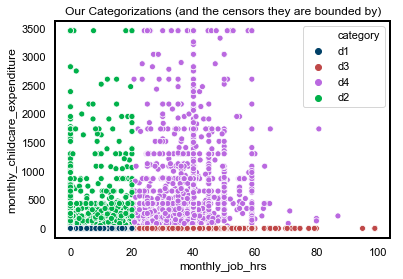

In [418]:
sns.scatterplot(x='monthly_job_hrs', y='monthly_childcare_expenditure', hue='category', palette=dave_palette[:],
               data=df).set_title("Our Categorizations (and the censors they are bounded by)")

Text(0.5, 1.0, "Working Mothers' Childcare Usage Not Determined By Hours")

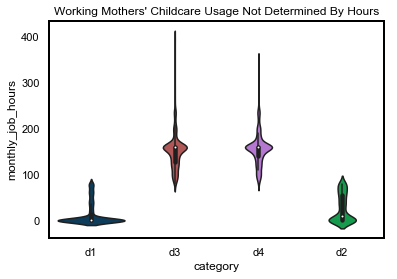

In [419]:
sns.violinplot(x='category', y='monthly_job_hours', palette=dave_palette,
            data=df).set_title("Working Mothers' Childcare Usage Not Determined By Hours")

In [401]:
df['has_kunder2'] = df.k_under2.apply(lambda x: True if x > 0 else False)

Text(0.5, 1.0, 'Having Children Under 2 Affects Working Women Differently')

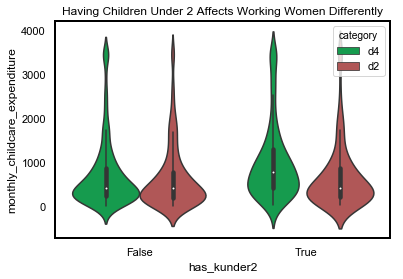

In [405]:
sns.violinplot(x='has_kunder2', y='monthly_childcare_expenditure', hue='category',
            palette=[dave_palette[3], dave_palette[1]], data=df[df.category.isin(['d2','d4'])]).set_title("Having Children Under 2 Affects Working Women Differently")

Text(0.5, 1.0, 'Wage vs Hours Across Categories')

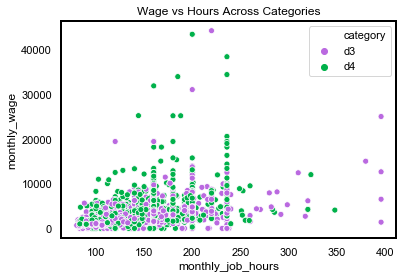

In [403]:
sns.scatterplot(x='monthly_job_hours', y='monthly_wage', hue='category',
            palette=[dave_palette[2], dave_palette[3]], data=df[df.category.isin(['d3', 'd4'])]).set_title("Wage vs Hours Across Categories")

Text(0.5, 0.98, 'Comparing Hours and Wage as Indicators Among Working Mothers')

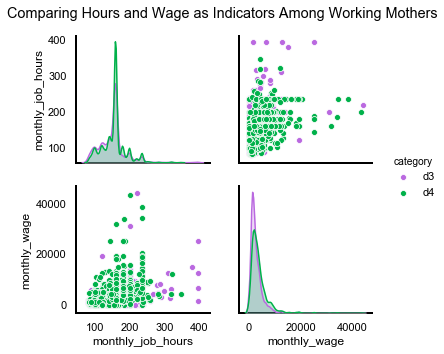

In [404]:
g = sns.pairplot(df[df.category.isin(['d3', 'd4'])][['category', 'monthly_job_hours', 'monthly_wage']],
             hue="category", palette=[dave_palette[2], dave_palette[3]])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Comparing Hours and Wage as Indicators Among Working Mothers')

In [406]:
df['binned_expenditure'] = pd.cut(list(df.monthly_childcare_expenditure), 5, labels=['low', 'med-low','med', 
                                                                           'med-high', 'high'])
df['payrate'] = df.monthly_wage / df.monthly_job_hours

In [407]:
df['binned_education'] = pd.cut(list(df.education), [0, 8, 12, 14, 16, 18, 100], labels=['Under 8th Grade',
                                                                            'Attended But did not Complete HS',
                                                                            'HS Graduates', 'College Exp',
                                                                            'Graduated College', 'Advanced Degree'])

In [408]:
df[df.category == 'd4'].shape

(1361, 33)

Text(0.5, 1.0, "Income Distribution Differences Between Working Mothers Who Do and Don't Utilize Childcare")

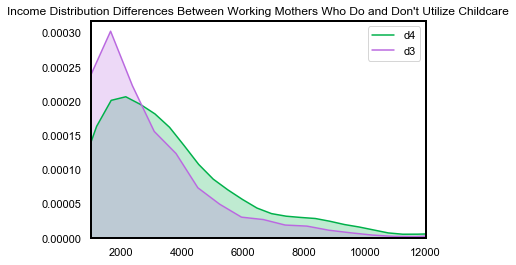

In [390]:
ax = sns.kdeplot(df[df.category == 'd4'].monthly_earned_income, color=dave_palette[3],
                 shade=True, legend=False)
sns.kdeplot(df[df.category == 'd3'].monthly_earned_income, ax=ax, color=dave_palette[2],
            shade=True, legend=False)
plt.xlim(1000, 12000)

plt.legend(labels=['d4', 'd3'])
plt.title("Income Distribution Differences Between Working Mothers Who Do and Don't Utilize Childcare")

In [391]:
df[df.monthly_childcare_expenditure < 0].shape

(0, 33)

Text(0.5, 1.0, 'Childcare Costs Distributed Similarly for Working and Non-Working Utilizers')

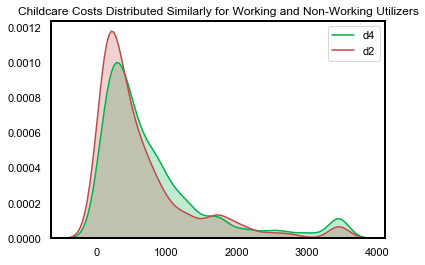

In [392]:
ax = sns.kdeplot(df[df.category == 'd4'].monthly_childcare_expenditure, color=dave_palette[3],
                 shade=True, legend=False)
sns.kdeplot(df[df.category == 'd2'].monthly_childcare_expenditure, ax=ax, color=dave_palette[1],
            shade=True, legend=False)

plt.legend(labels=['d4', 'd2'])
plt.title("Childcare Costs Distributed Similarly for Working and Non-Working Utilizers")

In [393]:
df['k_under5'] = df['k_under2'] + df['k_3to5']

Text(0.5, 1.0, "Kids Under 5 Distributed Similarly Between Women Who Do and Don't Utilize Childcare")

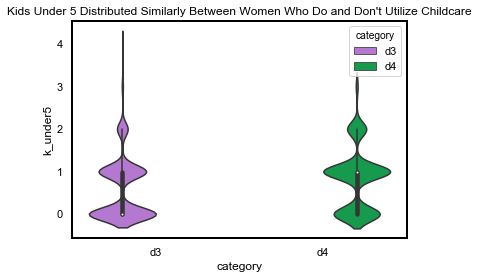

In [394]:
sns.violinplot(x='category', y='k_under5', hue='category',
           data=df[df.category.isin(['d3', 'd4'])], palette=[dave_palette[2], dave_palette[3]],
              ).set_title("Kids Under 5 Distributed Similarly Between Women Who Do and Don't Utilize Childcare")


Text(0.5, 1.0, 'Those Staying Home Had More Young Children')

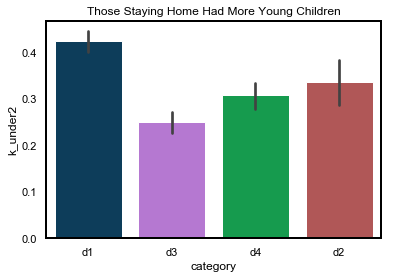

In [412]:
sns.barplot(x='category', y='k_under2', palette=[dave_palette[0], dave_palette[2], dave_palette[3],
                                                dave_palette[1]],
            data=df).set_title("Those Staying Home Had More Young Children")

Text(0.5, 1.0, 'Education Differences Between Categories')

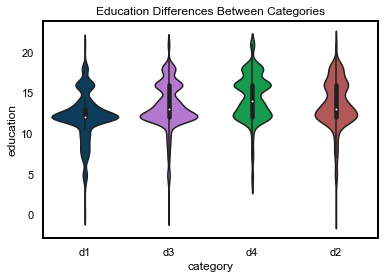

In [414]:
sns.violinplot(x='category', y='education', palette=[dave_palette[0], dave_palette[2], dave_palette[3],dave_palette[1]],
               data=df).set_title("Education Differences Between Categories")

In [145]:
df[df.d1 == 1].iloc[:, 10:].describe()

,monthly_job_hrs,monthly_wage,monthly_earned_income,monthly_unearned_income,education,age,southern,State_number,log_expenditure,H,F,intercept,monthly_job_hours,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4
count,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.0,2399.0,2399.0,2399.0,2399.000000,2399.000000,2399.000000,2399.0,2399.0,2399.0,2399.0
mean,3.203015,184.751906,256.573359,-223.812633,12.186953,32.028817,0.410866,27.267612,0.0,0.0,0.0,1.0,12.812058,10.545786,18.088666,1.0,0.0,0.0,0.0
std,5.999119,525.090619,633.491209,585.297744,2.873673,7.353559,0.489361,16.085341,0.0,0.0,0.0,0.0,23.996475,1.287874,1.924484,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,-11072.097222,0.000000,15.250000,0.000000,1.000000,0.0,0.0,0.0,1.0,0.000000,8.920000,14.700000,1.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,-224.343750,12.000000,26.458335,0.000000,13.000000,0.0,0.0,0.0,1.0,0.000000,9.500000,16.660000,1.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,12.000000,31.750000,0.000000,27.000000,0.0,0.0,0.0,1.0,0.000000,10.230000,17.800000,1.0,0.0,0.0,0.0
75%,3.570833,76.416667,252.166667,0.083333,13.000000,36.875000,1.000000,42.000000,0.0,0.0,0.0,1.0,14.283333,11.510000,19.210000,1.0,0.0,0.0,0.0
max,20.000000,9360.333333,11910.333333,436.333333,21.000000,57.833333,1.000000,56.000000,0.0,0.0,0.0,1.0,80.000000,13.310000,23.400000,1.0,0.0,0.0,0.0


In [60]:
df['total_income'] = df['monthly_earned_income'] + df['monthly_unearned_income']

In [ ]:
sns.boxplot(x='category', y='age', palette='husl',
            data=df).set_title("Mothers ")

In [ ]:
pairplot_ready = df[est_cols[1:] + ['age']]

In [ ]:
sns.pairplot(pairplot_ready, hue="age")

In [192]:
df.education.dtype

dtype('float64')